In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
latent_dim = 2

encoder_inputs = keras.Input(shape=(89, 1))
x = layers.Conv1D(8, 3, activation='relu', padding='same', dilation_rate=2)(encoder_inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same', dilation_rate=2)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
encoder = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(encoder)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(encoder)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(latent_inputs)
x = layers.Dense(89 * 8)(x)
x = layers.Reshape((89, 8))(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(8, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
decoded = layers.Conv1D(1, 3, activation='sigmoid', padding='same')(x)
decoded = layers.Cropping1D(cropping=(0, 267))(decoded)  # Crop to the desired output shape
decoder = keras.Model(latent_inputs, decoded, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    (data - reconstruction)**2, axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 89, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 89, 8)        32          ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 44, 8)        0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 44, 16)       400         ['max_pooling1d[0][0]']          
                                                                                            

In [2]:
#(x_train) = pd.read_csv('train_dataset.csv')
#(x_test) = pd.read_csv('test_dataset.csv')
df = pd.read_csv('amp+avp_features.csv')
(x_train, x_test) = train_test_split(df, test_size=0.2, random_state=42)

from sklearn.preprocessing import MinMaxScaler, Normalizer

# Separate the last column from x_train and x_test
x_train_last_col = x_train['label']
x_test_last_col = x_test['label']

# Convert the remaining columns to NumPy arrays
x_train_features = x_train.drop('label', axis=1).values
x_test_features = x_test.drop('label', axis=1).values

# Apply scaling and normalization to the features
scaler = MinMaxScaler()
normalizer = Normalizer()

x_train_scaled = scaler.fit_transform(x_train_features)
x_train_scaled_normalized = normalizer.fit_transform(x_train_scaled)

x_test_scaled = scaler.transform(x_test_features)
x_test_scaled_normalized = normalizer.transform(x_test_scaled)

# Concatenate the normalized features with the last column
x_train_processed = np.hstack((x_train_scaled_normalized, x_train_last_col.values[:, np.newaxis]))
x_test_processed = np.hstack((x_test_scaled_normalized, x_test_last_col.values[:, np.newaxis]))

#print(x_train.shape)
#print(x_test.shape)
peptides = np.concatenate([x_train, x_test], axis=0)
#print(peptides.shape)
peptides = np.expand_dims(peptides, -1)
#print(peptides.shape)

In [3]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
#vae.fit(peptides, batch_size=50, epochs=8)
vae.fit(peptides, batch_size=128, epochs=10)

Epoch 1/10
82/82 [==============================] - 3s 14ms/step - loss: 77.2030 - reconstruction_loss: 65.6957 - kl_loss: 0.9985
Epoch 2/10
82/82 [==============================] - 1s 14ms/step - loss: 50.1114 - reconstruction_loss: 49.9298 - kl_loss: 0.0838
Epoch 3/10
82/82 [==============================] - 1s 15ms/step - loss: 49.5147 - reconstruction_loss: 49.4987 - kl_loss: 0.0131
Epoch 4/10
82/82 [==============================] - 1s 13ms/step - loss: 50.0767 - reconstruction_loss: 48.9795 - kl_loss: 0.0102
Epoch 5/10
82/82 [==============================] - 1s 14ms/step - loss: 48.5837 - reconstruction_loss: 48.7488 - kl_loss: 0.0088
Epoch 6/10
82/82 [==============================] - 1s 14ms/step - loss: 48.7052 - reconstruction_loss: 48.5959 - kl_loss: 0.0085
Epoch 7/10
82/82 [==============================] - 1s 14ms/step - loss: 48.5988 - reconstruction_loss: 48.5809 - kl_loss: 0.0080
Epoch 8/10
82/82 [==============================] - 1s 13ms/step - loss: 48.2879 - reconst

(8367, 89)
262/262 [==============================] - 0s 1ms/step
7364    2
611     3
3333    3
9483    1
511     2
       ..
5734    2
5191    2
5390    2
860     2
7270    3
Name: label, Length: 8367, dtype: int64
(8367,)


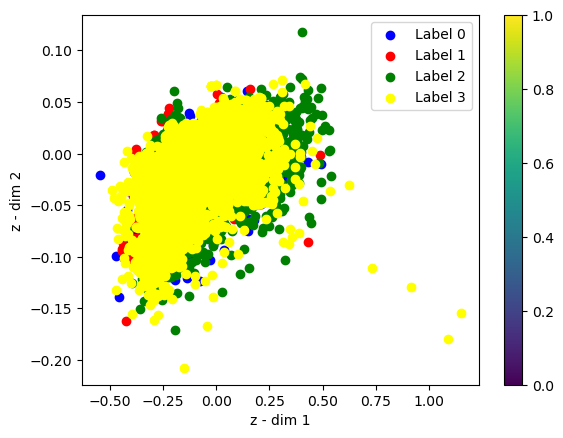

In [4]:
#VIZUALIZACIJA
import matplotlib.pyplot as plt

img_width = 89
img_height = 1
num_channels = 1

def viz_latent_space(encoder, data, labels):
    input_data, target_data = data
    mu, _, _ = encoder.predict(input_data)
    labels = input_data['label']
    print(labels)
    print(labels.shape)
    # Plot points with label 0 in blue
    plt.scatter(mu[labels == 0, 0], mu[labels == 0, 1], c='blue', label='Label 0')
    
    # Plot points with label 1 in red
    plt.scatter(mu[labels == 1, 0], mu[labels == 1, 1], c='red', label='Label 1')
    
    # Plot points with label 2 in green
    plt.scatter(mu[labels == 2, 0], mu[labels == 2, 1], c='green', label='Label 2')
    
    # Plot points with label 3 in yellow
    plt.scatter(mu[labels == 3, 0], mu[labels == 3, 1], c='yellow', label='Label 3')
    
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.colorbar()
    plt.legend()
    plt.show()
    
label_data = pd.read_csv('tmp.csv')
labels = label_data['Antiviral'].values
    
data = (x_train, x_test)
print(x_train.shape)
viz_latent_space(encoder, data, labels)   